<div class="alert alert-block alert-warning">

### Гипотеза 1

По идее, должна быть разница в поведении групп, которые проходят и не проходят обучение. Но так ли это? Влияет ли обучение на скорость прохождения других этапов игры?
### Гипотеза 2

Кажется, повторное прохождение обучения положительно влияет на оплату, верно?
### Гипотеза 3

Если пользователь сначала выбирает сложность обучения, будет ли он потом проходить обучение?
</div>

<div class="alert alert-block alert-warning">

### Задачи:
### Определить, насколько обучение сокращает время прохождения этапов игры.
### Доказать, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.
### Определить, насколько прозрачен процесс взаимодействия с игрой.

</div>

In [37]:
#  загружаем данные
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

events_df = pd.read_csv('data/Events.csv')
purchase_df = pd.read_csv('data/purchase.csv')

### готовим таблицу events_df

In [38]:
# фильтруем по условию: пользователи, зарегистрировавшиеся в 2018 году
mask = (events_df.start_time >= '2018-01-01') & (events_df.start_time < '2019-01-01') & (events_df.event_type == 'registration')
b_list = events_df[mask].user_id.unique() # список уникальных пользователей за 2018 год
events_2018 = events_df[events_df.user_id.isin(b_list)] # датафрейм событий
events_2018.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66959 entries, 51405 to 118364
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              66959 non-null  int64  
 1   event_type      66959 non-null  object 
 2   selected_level  8342 non-null   object 
 3   start_time      66959 non-null  object 
 4   tutorial_id     32954 non-null  float64
 5   user_id         66959 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 3.6+ MB


### готовим таблицу purchase_df

In [39]:
purchase_2018 = purchase_df[purchase_df.user_id.isin(b_list)] # оставим пользователей за 2018 год
# датафрейм оплат
purchase_2018.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600 entries, 1171 to 2778
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              1600 non-null   int64 
 1   user_id         1600 non-null   int64 
 2   event_datetime  1600 non-null   object
 3   amount          1600 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 62.5+ KB


### готовим общую таблицу событий и оплат

In [40]:
# преобразуем столбцы для объединения таблиц по строкам
events_2018 = events_2018.rename(columns={"id": "event_id"})
purchase_2018 = purchase_2018.rename(columns={"id": "purchase_id", "event_datetime": "start_time"})

# добавляем признак оплат
purchase_2018['event_type'] = 'purchase'

# объединяем и сортируем, также сбрасываем индексы
total_events_2018 = pd.concat([events_2018,purchase_2018],sort=False)
total_events_2018 = total_events_2018.reset_index(drop=True).sort_values('start_time')
total_events_2018.start_time = pd.to_datetime(total_events_2018.start_time) # преобразуем столбец дат в тип данных: datetime

display(total_events_2018.head())
total_events_2018.info()

,event_id,event_type,selected_level,start_time,tutorial_id,user_id,purchase_id,amount
0,80308.0,registration,NaN,2018-01-01 03:48:40,NaN,27832,NaN,NaN
1,80309.0,registration,NaN,2018-01-01 04:07:25,NaN,27833,NaN,NaN
2,80310.0,registration,NaN,2018-01-01 08:35:10,NaN,27834,NaN,NaN
3,80311.0,registration,NaN,2018-01-01 11:54:47,NaN,27835,NaN,NaN
4,80312.0,registration,NaN,2018-01-01 13:28:07,NaN,27836,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 68559 entries, 0 to 68558
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   event_id        66959 non-null  float64       
 1   event_type      68559 non-null  object        
 2   selected_level  8342 non-null   object        
 3   start_time      68559 non-null  datetime64[ns]
 4   tutorial_id     32954 non-null  float64       
 5   user_id         68559 non-null  int64         
 6   purchase_id     1600 non-null   float64       
 7   amount          1600 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 4.7+ MB


In [41]:
total_events_2018.describe()

,event_id,tutorial_id,user_id,purchase_id,amount
count,66959.000000,32954.000000,68559.000000,1600.000000,1600.000000
mean,113787.000045,40532.934393,37780.871775,17645.505625,110.734375
std,19329.542752,5213.486632,5753.126469,462.038637,54.696628
min,80308.000000,31505.000000,27832.000000,16845.000000,25.000000
25%,97047.500000,36008.250000,32848.500000,17245.750000,50.000000
50%,113787.000000,40529.500000,37717.000000,17645.500000,100.000000
75%,130526.500000,45057.750000,42742.500000,18045.250000,150.000000
max,147267.000000,49554.000000,47757.000000,18452.000000,300.000000


###  Задача 1 - Определить, насколько обучение сокращает время прохождения этапов игры.
Чтобы это понять, надо сравнить время прохождения различных этапов для пользователей, которые завершили обучение, и пользователей, не начинавших обучение. Если показатель отличается, выяснить, насколько

In [42]:
x = total_events_2018['event_type'].unique()
display(x) # события в event_type

array(['registration', 'tutorial_start', 'tutorial_finish',
       'level_choice', 'pack_choice', 'purchase'], dtype=object)

In [43]:
# Делим датафреймы на два
users_tutorial_finish = total_events_2018[total_events_2018["event_type"] == "tutorial_finish"].user_id.unique() # пользователи, закончившие обучение
users_tutorial_start = total_events_2018[total_events_2018["event_type"] == "tutorial_start"].user_id.unique() # пользователи, начавшие обучение

users_without_tutorial1 = total_events_2018.user_id.apply(lambda x: x if x not in users_tutorial_start else False) 
users_without_tutorial = users_without_tutorial1[users_without_tutorial1 != False].to_list() # пользователи, не начинавшие обучение

total_events_whith = total_events_2018[total_events_2018.user_id.isin(users_tutorial_finish)] # датафрейм пользователей с обучением

total_events_whithout = total_events_2018[total_events_2018.user_id.isin(users_without_tutorial)] # датафрейм пользователей без обучения


### начнём с пользователей, завершивших обучение

In [44]:
# готовим датафреймы
registration_df = total_events_whith[total_events_whith['event_type'] == 'registration'][['user_id','start_time']]

level_choice_df = total_events_whith[total_events_whith['event_type'] == 'level_choice'][['user_id','start_time']].sort_values('start_time').drop_duplicates('user_id')
level_choice_df = level_choice_df.rename(columns = {'start_time' : 'level_choice_time'}) # датафрейм со временем выбора уровня сложности

pack_choice_df = total_events_whith[total_events_whith['event_type'] == 'pack_choice'][['user_id','start_time']].sort_values('start_time').drop_duplicates('user_id')
pack_choice_df = pack_choice_df.rename(columns = {'start_time' : 'pack_choice_time'}) # датафрейм со временем выбора бесплатного пакета вопросов

purchase = total_events_whith[total_events_whith['event_type'] == 'purchase'][['user_id','start_time']]
purchase = purchase.rename(columns = {'start_time' : 'purchase_time'}) # датафрейм со временем оплат

print("каждый пользователь покупает 1 раз?", purchase.user_id.count() == purchase.user_id.nunique())
print("каждый пользователь выбирает пакет 1 раз?", pack_choice_df.user_id.count() == pack_choice_df.user_id.nunique())
print("каждый пользователь выбирает сложность 1 раз?", level_choice_df.user_id.count() == level_choice_df.user_id.nunique())

каждый пользователь покупает 1 раз? True
каждый пользователь выбирает пакет 1 раз? True
каждый пользователь выбирает сложность 1 раз? True


### Соединяем датафреймы

In [45]:
total_df = registration_df.merge(level_choice_df, how = 'left', on = 'user_id')
total_df = total_df.merge(pack_choice_df, how = 'left', on = 'user_id')
total_df = total_df.merge(purchase, how = 'left', on = 'user_id')

total_df.head()

,user_id,start_time,level_choice_time,pack_choice_time,purchase_time
0,27833,2018-01-01 04:07:25,NaT,NaT,NaT
1,27834,2018-01-01 08:35:10,NaT,NaT,NaT
2,27835,2018-01-01 11:54:47,2018-01-01 20:37:22,2018-01-01 20:38:43,NaT
3,27836,2018-01-01 13:28:07,NaT,NaT,NaT
4,27839,2018-01-01 18:24:01,2018-01-01 22:37:50,2018-01-01 22:42:54,NaT


### готовим датафреймы пользователей, не начинавших обучение

In [46]:
# готовим датасеты аналогично предыдущим, но для пользователей без обучения
registration_df1 = total_events_whithout[total_events_whithout['event_type'] == 'registration'][['user_id','start_time']]

level_choice_df1 = total_events_whithout[total_events_whithout['event_type'] == 'level_choice'][['user_id','start_time']].sort_values('start_time').drop_duplicates('user_id')
level_choice_df1 = level_choice_df1.rename(columns = {'start_time' : 'level_choice_time'})

pack_choice_df1 = total_events_whithout[total_events_whithout['event_type'] == 'pack_choice'][['user_id','start_time']].sort_values('start_time').drop_duplicates('user_id')
pack_choice_df1 = pack_choice_df1.rename(columns = {'start_time' : 'pack_choice_time'})

purchase1 = total_events_whithout[total_events_whithout['event_type'] == 'purchase'][['user_id','start_time']]
purchase1 = purchase1.rename(columns = {'start_time' : 'purchase_time'})

# проверка
print("каждый пользователь покупает 1 раз?", purchase1.user_id.count() == purchase1.user_id.nunique())
print("каждый пользователь выбирает пакет 1 раз?", pack_choice_df1.user_id.count() == pack_choice_df1.user_id.nunique())
print("каждый пользователь выбирает сложность 1 раз?", level_choice_df1.user_id.count() == level_choice_df1.user_id.nunique())

каждый пользователь покупает 1 раз? True
каждый пользователь выбирает пакет 1 раз? True
каждый пользователь выбирает сложность 1 раз? True


### Соединяем датафреймы

In [47]:
total_df1 = registration_df1.merge(level_choice_df1, how = 'left', on = 'user_id')
total_df1 = total_df1.merge(pack_choice_df1, how = 'left', on = 'user_id')
total_df1 = total_df1.merge(purchase1, how = 'left', on = 'user_id')

total_df1['gruop_without'] = 'no_tutorial' # присваиваем новый признак, без обучения и с обучением
total_df['gruop_without'] = 'yes_tutorial'

display( 'воронка - пользователи без обучения', total_df1.count(), 
      'воронка - пользователи с обучением',
       total_df.count())

vizual_df = total_df.count()
vizual_df1 = total_df1.count()

'воронка - пользователи без обучения'

user_id              8068
start_time           8068
level_choice_time      98
pack_choice_time       74
purchase_time          22
gruop_without        8068
dtype: int64

'воронка - пользователи с обучением'

user_id              10250
start_time           10250
level_choice_time     7501
pack_choice_time      5176
purchase_time         1447
gruop_without        10250
dtype: int64

In [48]:
# готов датафреймы для визуализации данных

vizual_df = pd.DataFrame(vizual_df, index = vizual_df.index)
vizual_df = vizual_df.rename_axis('события').reset_index()
vizual_df.columns = ['события', "число пользователей"]
vizual_df = vizual_df.loc[1:4, :]

vizual_df1 = pd.DataFrame(vizual_df1, index = vizual_df1.index)
vizual_df1 = vizual_df1.rename_axis('события').reset_index()
vizual_df1.columns = ['события', "число пользователей"]
vizual_df1 = vizual_df1.loc[1:4, :]

# здесь 'start_time' - время регистрации
display(vizual_df)
display(vizual_df1)

,события,число пользователей
1,start_time,10250
2,level_choice_time,7501
3,pack_choice_time,5176
4,purchase_time,1447


,события,число пользователей
1,start_time,8068
2,level_choice_time,98
3,pack_choice_time,74
4,purchase_time,22


### строим визуализацию воронки

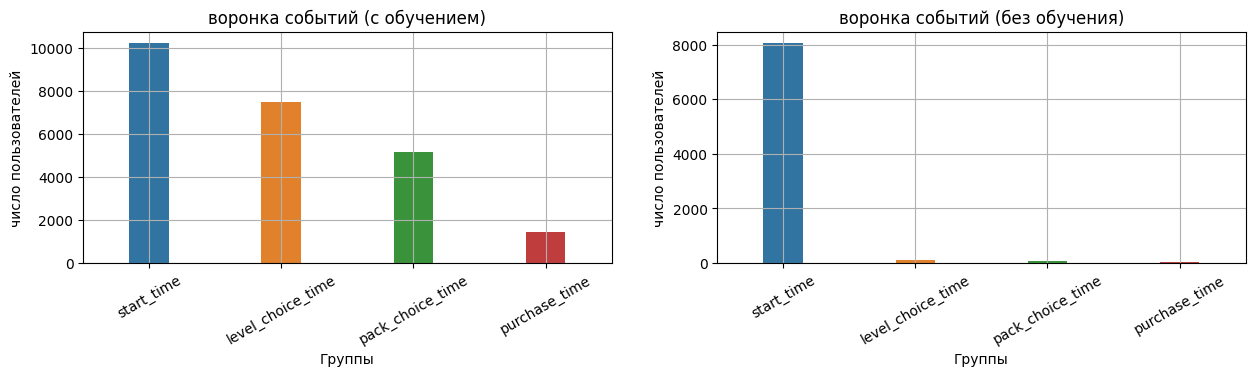

In [49]:
fig,axes = plt.subplots(1,2, figsize = (15,3))

sns.barplot(
    data=vizual_df,
    x = 'события',
    y = 'число пользователей',
    orient='v',
    width=0.3,
    ax = axes[0]);

axes[0].set_title('воронка событий (с обучением)')
axes[0].set_xlabel('Группы')
axes[0].grid()
axes[0].xaxis.set_tick_params(rotation=30)
    
sns.barplot(
    data=vizual_df1, 
    x = 'события',
    y = 'число пользователей',
    orient='v',
    width=0.3,
    ax = axes[1]);

axes[1].set_title('воронка событий (без обучения)')
axes[1].set_xlabel('Группы')
axes[1].grid()
axes[1].xaxis.set_tick_params(rotation=30)

# start_time - время регистрации, обязательный для всех параметр

### как видно, воронка больше у группы пользователей, которые завершили обучение! ИЛИ так

In [50]:
# готовим таблицу
vizual_df1['groups'] = 'no-tutorial'
vizual_df['groups'] = 'yes-tutorial'
vizual_df = pd.concat([vizual_df, vizual_df1], ignore_index=True)
vizual_df

,события,число пользователей,groups
0,start_time,10250,yes-tutorial
1,level_choice_time,7501,yes-tutorial
2,pack_choice_time,5176,yes-tutorial
3,purchase_time,1447,yes-tutorial
4,start_time,8068,no-tutorial
5,level_choice_time,98,no-tutorial
6,pack_choice_time,74,no-tutorial
7,purchase_time,22,no-tutorial


In [51]:
fig = px.funnel(vizual_df, 
                y='события', 
                x='число пользователей', 
                color='groups', 
                orientation='h', 
                height=500, #высота
                width=600 #ширина
                )
fig.show()
# fig.write_html(r"E:\репозитории\for_Python/funnel_3d.html")

In [52]:
# объединяю датайремы в один
total_group_df = pd.concat([total_df, total_df1])
total_group_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18318 entries, 0 to 8067
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18318 non-null  int64         
 1   start_time         18318 non-null  datetime64[ns]
 2   level_choice_time  7599 non-null   datetime64[ns]
 3   pack_choice_time   5250 non-null   datetime64[ns]
 4   purchase_time      1469 non-null   datetime64[ns]
 5   gruop_without      18318 non-null  object        
dtypes: datetime64[ns](4), int64(1), object(1)
memory usage: 1001.8+ KB


### надо проверить правильность данных

In [53]:
# мы брали пользователей, завершивших обучение хотя бы раз и тех, кто не начинал обучение, но остались пользователи, которые начали обучение и не закончили.
print('все пользователи', total_events_2018.user_id.nunique())
print('закончили обучение', total_events_2018[total_events_2018['event_type'] == 'tutorial_finish'].user_id.nunique())
print('начали обучение, но не закончили', total_events_2018[total_events_2018['event_type'] == 'tutorial_start'].user_id.nunique() -
total_events_2018[total_events_2018['event_type'] == 'tutorial_finish'].user_id.nunique())
print('сумма двух датафреймов с вычетом пользователей, не закончивших обучение', total_events_whithout.user_id.nunique() + total_events_whith.user_id.nunique())
print('новый объединённый датафрейм, должно совпадать количество пользователей', total_group_df.user_id.nunique())

count_all_users = total_events_2018.user_id.nunique() # пригодится в будущем

все пользователи 19926
закончили обучение 10250
начали обучение, но не закончили 1608
сумма двух датафреймов с вычетом пользователей, не закончивших обучение 18318
новый объединённый датафрейм, должно совпадать количество пользователей 18318


In [54]:
# через diff считаю разницу во времени между каждым этапом
# start_time - время регистрации

total_group_df = total_group_df.set_index('gruop_without') # уберу признак групп в иднекс датафрейма

total_diff_df = total_group_df[['start_time', 'level_choice_time', 'pack_choice_time', 'purchase_time']].diff(axis = 1)

total_diff_df.pivot_table(
    values=['level_choice_time', 'pack_choice_time', 'purchase_time'],
    columns = total_diff_df.index,
    aggfunc = ['describe']
)



describe                           
gruop_without                          no_tutorial               yes_tutorial
level_choice_time 25%       0 days 02:15:28.500000            0 days 03:51:41
                  50%       0 days 04:56:05.500000            0 days 06:00:07
                  75%              0 days 08:24:01            0 days 09:25:42
                  count                         98                       7501
                  max              0 days 18:34:21            1 days 18:48:25
                  mean   0 days 05:15:33.122448979  0 days 07:05:36.854819357
                  min              0 days 00:09:26            0 days 00:08:15
                  std    0 days 03:41:00.594664298  0 days 04:30:23.231509186
pack_choice_time  25%       0 days 00:03:09.750000            0 days 00:03:05
                  50%       0 days 00:04:46.500000            0 days 00:04:58
                  75%       0 days 00:07:11.250000            0 days 00:07:11
                  count                         74                       5176
                  max              0 days 00:13:32            0 days 00:15:48
                  mean   0 days 00:05:23.824324324  0 days 00:05:18.146058732
                  min              0 days 00:00:48            0 days 00:00:19
                  std    0 days 00:03:01.230146431  0 days 00:02:44.449118501
purchase_time     25%              2 days 15:49:22     1 days 21:16:05.500000
                  50%              4 days 04:38:42            3 days 12:15:56
                  75%       5 days 23:34:55.750000     5 days 08:53:44.500000
                  count                         22                       1447
                  max              7 days 11:56:49           10 days 18:33:59
                  mean   4 days 04:49:33.590909090  3 days 17:17:59.641326883
                  min              0 days 09:35:48            0 days 00:44:50
                  std    2 days 04:58:40.602573417  2 days 04:31:59.804658578

In [55]:
# время между началом (регистрацией) и оплатой
total_group_df['delta'] =  total_group_df.purchase_time - total_group_df['start_time']
total_group_df.groupby(total_group_df.index)['delta'].describe()

,count,mean,std,min,25%,50%,75%,max
gruop_without,,,,,,,,
no_tutorial,22,4 days 09:06:01.909090909,2 days 05:12:16.748091626,0 days 09:59:07,2 days 21:31:31,4 days 11:29:09,6 days 02:28:47.750000,7 days 16:46:20
yes_tutorial,1447,4 days 00:30:03.247408431,2 days 04:47:29.946150698,0 days 04:36:58,2 days 04:09:55,3 days 19:04:59,5 days 15:46:14,11 days 00:35:04


In [56]:
# готовлю данные для визуализации
pivot = total_diff_df[['level_choice_time', 'pack_choice_time', 'purchase_time']]
pivot = (pivot[['level_choice_time', 'pack_choice_time', 'purchase_time']]/pd.Timedelta(hours = 1)).copy()
pivot = pivot.groupby(pivot.index)[['level_choice_time', 'pack_choice_time', 'purchase_time']].mean()
pivot

,level_choice_time,pack_choice_time,purchase_time
gruop_without,,,
no_tutorial,5.259201,0.089951,100.825997
yes_tutorial,7.093571,0.088374,89.299900


,count,mean,std,min,25%,50%,75%,max
gruop_without,,,,,,,,
no_tutorial,22,4 days 09:06:01.909090909,2 days 05:12:16.748091626,0 days 09:59:07,2 days 21:31:31,4 days 11:29:09,6 days 02:28:47.750000,7 days 16:46:20
yes_tutorial,1447,4 days 00:30:03.247408431,2 days 04:47:29.946150698,0 days 04:36:58,2 days 04:09:55,3 days 19:04:59,5 days 15:46:14,11 days 00:35:04


' - таблица разности между оплатой и регистрацией для двух групп'

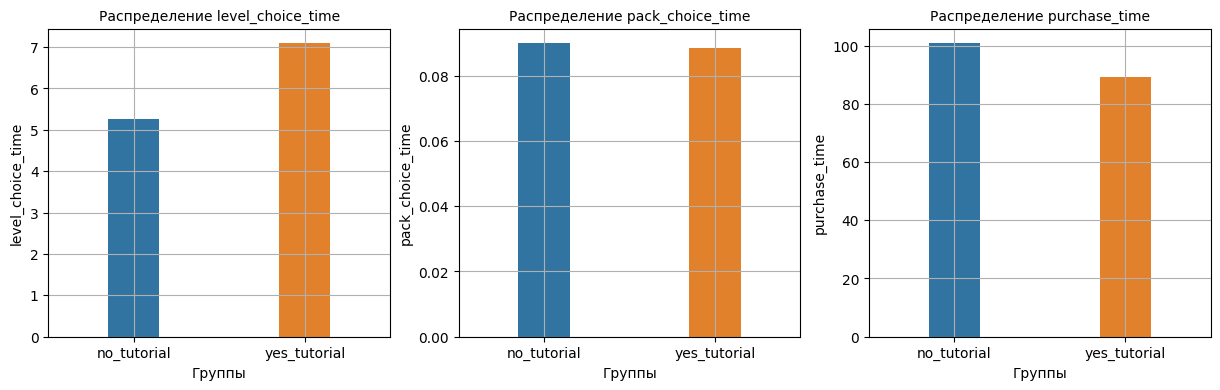

In [57]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
sns.barplot(
    data=pivot,
    y = 'level_choice_time', 
    orient='v',
    x = pivot.index,
    width=0.3,
    ax = axes[0]
)
axes[0].set_title('Распределение level_choice_time', fontsize = (10));
axes[0].set_xlabel('Группы')
axes[0].grid()

sns.barplot(
    data=pivot,
    y = 'pack_choice_time', 
    orient='v',
    x = pivot.index,
    width=0.3,
    ax = axes[1]
)
axes[1].set_title('Распределение pack_choice_time', fontsize = (10));
axes[1].grid()
axes[1].set_xlabel('Группы')

sns.barplot(
    data=pivot,
    y = 'purchase_time', 
    orient='v',
    x = pivot.index,
    width=0.3,
    ax = axes[2]
)
axes[2].set_title('Распределение purchase_time', fontsize = (10));
axes[2].set_xlabel('Группы')
axes[2].grid()

display(total_group_df.groupby(total_group_df.index)['delta'].describe(), ' - таблица разности между оплатой и регистрацией для двух групп')

Для пользователей, прошедших обучение, процесс оплаты с момента регистрации в среднем на 8,5 часов быстрее, чем у 2 группы ( пользователей, не прошедших обучение), далее буду говорить о группах 1 (с обучением) и 2 (без обучения).

Группа 1 выбирает уровень сложности на 2,2 часа дольше 2 группы. Далее группа 1 выбирает бесплатный пакет и покупает платный пакет вопросов быстрее(5 минут и 11 часов соответственно), в итоге 1 группа быстрее совершает оплату! Вывод: для пользователей, прошедших обучение, время между этапами различается по сравнению с пользователями, не прошедшими обучение.

### Задача 2: поверить, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь.

In [58]:
# работаем с датафреймом
total_events_2018.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68559 entries, 0 to 68558
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   event_id        66959 non-null  float64       
 1   event_type      68559 non-null  object        
 2   selected_level  8342 non-null   object        
 3   start_time      68559 non-null  datetime64[ns]
 4   tutorial_id     32954 non-null  float64       
 5   user_id         68559 non-null  int64         
 6   purchase_id     1600 non-null   float64       
 7   amount          1600 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 4.7+ MB


In [59]:
# продолжаем работу с датафреймом - total_events_2018
total_events_2018 = total_events_2018.reset_index(drop=True).sort_values(['user_id','start_time'])
user_path_df = total_events_2018.groupby("user_id")["event_type"].apply(list).reset_index()
display(user_path_df.head(10))

# преобразуем кортеж в строку в каждой ячейке, это ускорит обработку данных
user_path_df["event_path"] = user_path_df["event_type"].apply(lambda x: " > ".join(x))
user_path_df["event_path"].head(10) 

,user_id,event_type
0,27832,[registration]
1,27833,"[registration, tutorial_start, tutorial_finish]"
2,27834,"[registration, tutorial_start, tutorial_finish]"
3,27835,"[registration, tutorial_start, tutorial_finish..."
4,27836,"[registration, tutorial_start, tutorial_start,..."
5,27837,[registration]
6,27838,[registration]
7,27839,"[registration, tutorial_start, tutorial_finish..."
8,27840,"[registration, tutorial_start, level_choice]"
9,27841,"[registration, tutorial_start, tutorial_finish]"


0                                         registration
1      registration > tutorial_start > tutorial_finish
2      registration > tutorial_start > tutorial_finish
3    registration > tutorial_start > tutorial_finis...
4    registration > tutorial_start > tutorial_start...
5                                         registration
6                                         registration
7    registration > tutorial_start > tutorial_finis...
8         registration > tutorial_start > level_choice
9      registration > tutorial_start > tutorial_finish
Name: event_path, dtype: object

In [60]:
# самые популярные пользовательские пути
user_paths = (
    user_path_df.groupby(["event_path"])["user_id"]
    .nunique() # хотя можно и count - нет разницы в данный момент.
    .sort_values(ascending=False)
)
user_paths.head(10)

event_path
registration                                                                                                       7970
registration > tutorial_start > tutorial_finish > level_choice > pack_choice                                       2796
registration > tutorial_start > tutorial_finish                                                                    1956
registration > tutorial_start > tutorial_finish > level_choice                                                     1713
registration > tutorial_start > tutorial_finish > level_choice > pack_choice > purchase                            1083
registration > tutorial_start                                                                                       842
registration > tutorial_start > level_choice > pack_choice                                                          346
registration > tutorial_start > tutorial_finish > tutorial_start > tutorial_finish                                  323
registration > tutorial_start

In [61]:
# Ищем последовательности с оплатой
display(user_paths[user_paths.index.str.contains('purchase')].head(10))

event_path
registration > tutorial_start > tutorial_finish > level_choice > pack_choice > purchase                                                                                                             1083
registration > tutorial_start > level_choice > pack_choice > purchase                                                                                                                                124
registration > tutorial_start > tutorial_finish > level_choice > pack_choice > tutorial_start > tutorial_finish > purchase                                                                           101
registration > tutorial_start > tutorial_finish > tutorial_start > tutorial_finish > level_choice > pack_choice > purchase                                                                            52
registration > tutorial_start > tutorial_start > tutorial_finish > level_choice > pack_choice > purchase                                                                                 

In [62]:
# Ищем последовательности с оплатой и обучением
mask1 = user_paths.index.str.contains('purchase')
mask2 = user_paths.index.str.contains('tutorial_start')

display(user_paths[(mask1)&(mask2)].head(10)) # самые популярные пути с оплатой и обучением

purchase_count = user_paths[(mask1)&(mask2)]
print(purchase_count.sum(), 'количество оплат, где было хотя бы 1 обучение')
print(total_events_2018.amount.count(), 'количество оплат всего')

purchase_count = user_paths[(mask1)&(mask2)].head(6) # оставлю 6 самых популярный путей для графика

event_path
registration > tutorial_start > tutorial_finish > level_choice > pack_choice > purchase                                                                                                             1083
registration > tutorial_start > level_choice > pack_choice > purchase                                                                                                                                124
registration > tutorial_start > tutorial_finish > level_choice > pack_choice > tutorial_start > tutorial_finish > purchase                                                                           101
registration > tutorial_start > tutorial_finish > tutorial_start > tutorial_finish > level_choice > pack_choice > purchase                                                                            52
registration > tutorial_start > tutorial_start > tutorial_finish > level_choice > pack_choice > purchase                                                                                 

1578 количество оплат, где было хотя бы 1 обучение
1600 количество оплат всего


In [63]:
# процент оплат для пользователей, где был старт обучения
print(round(100*1578/1600,2), '%')
# в расчётах по 1 задаче выше я показывал, что 22 оплаты пришлось на пользователей, которые не проходили обучение

98.62 %


#### Значит: registration > tutorial_start > tutorial_finish > level_choice > pack_choice > purchase - самый популярный путь с 1 законченным обучением, который приводит к оплате.
#### registration > tutorial_start > level_choice > pack_choice > purchase - 2 путь по популярности, в нём обучение не закончено. 
3 и 4 пути (с повторным обучением), примерно, равны со 2-ым. Один пользователь - одна оплата, итого 1600 оплат, 1578 приходится на пользователей с обучением или 98.62% (1447 для тех, кто завершил обучение или прошёл дваджы, значит 1578 - 1447 = 131 оплата на пользователей с незаконченным обучением и 22 без обучения).

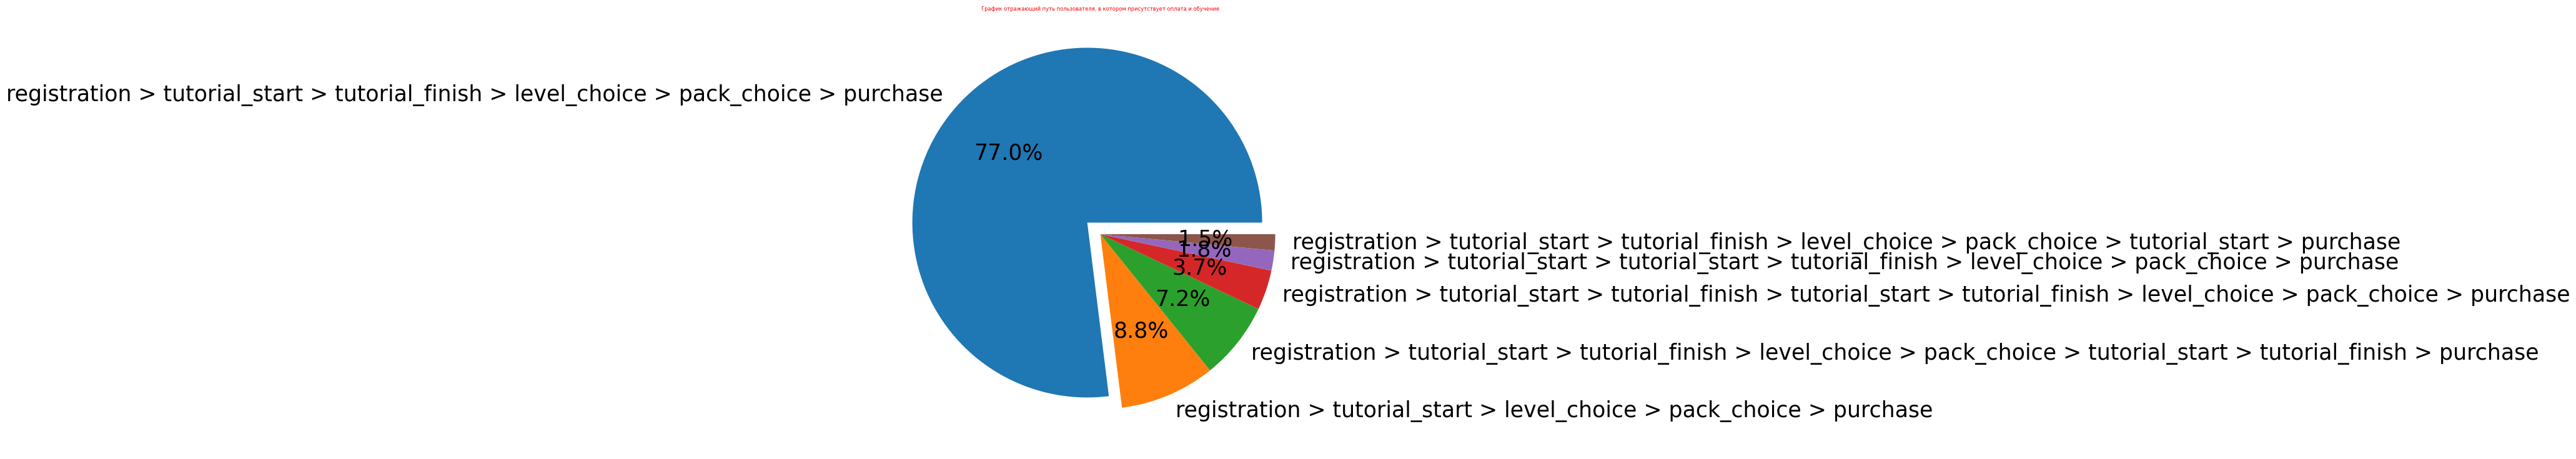

In [64]:
purchase_count

fig = plt.figure(figsize=(15, 7))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    x = purchase_count,
    labels = purchase_count.index,
    autopct ='%.1f%%',
    textprops={'fontsize': 25},
    explode = [0.1, 0, 0, 0, 0, 0]
    
);
axes.set_title('График отражающий путь пользователя, в котором присутствует оплата и обучение', fontsize = 6, color = 'red');

Вывод : нет зависимостей между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь. Так как 76.3% - это группа, закончившая обучение 1 раз. Возможно даже и такое, чем чаще пользователь возвращается к обучению,тем больше падает процент оплат, так как пользователь не понимает игру.

### поделю пользователей на группы в зависимости от количества обучений.

In [65]:
df = total_events_2018[total_events_2018['event_type'].isin(['tutorial_start'])][['user_id', 'event_type']]
df = df.user_id.value_counts().sort_values()
df = df.reset_index()
df.columns = ['user_id', 'number_groups']
display(df.number_groups.unique()) # номера групп, пример: 1 обучение - 1 группа, 2 обучения - 2 группа и т.д.

# соединяю датафреймы с исходным
total_events_2018 = total_events_2018.merge(df, on = 'user_id', how = 'inner')

# подготовим датафрейм для подсчёта конверсии в покупку для каждой группы
df2 = total_events_2018.groupby('number_groups', as_index = False)[['user_id', 'purchase_id']].nunique()
#  напомню, что 1 пользователь совершает покупку 1 раз. Поэтому считаю через метод: nunique

print(df2.info()) # промежуточный результат

df2['percent'] = round(100 * df2.purchase_id/df2.user_id,2)

# переименуем столбцы
df2.columns = ['number_groups',  'count_user_id',  'count_purchase_id', 'percent'] 
df2 = df2.sort_values('percent', ascending = False)
display(df2)

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   number_groups  9 non-null      int64
 1   user_id        9 non-null      int64
 2   purchase_id    9 non-null      int64
dtypes: int64(3)
memory usage: 344.0 bytes
None


,number_groups,count_user_id,count_purchase_id,percent
7,8,86,13,15.12
8,9,113,17,15.04
4,5,109,16,14.68
1,2,1589,218,13.72
3,4,221,30,13.57
0,1,9103,1207,13.26
6,7,94,12,12.77
5,6,116,14,12.07
2,3,427,51,11.94


### построим график?

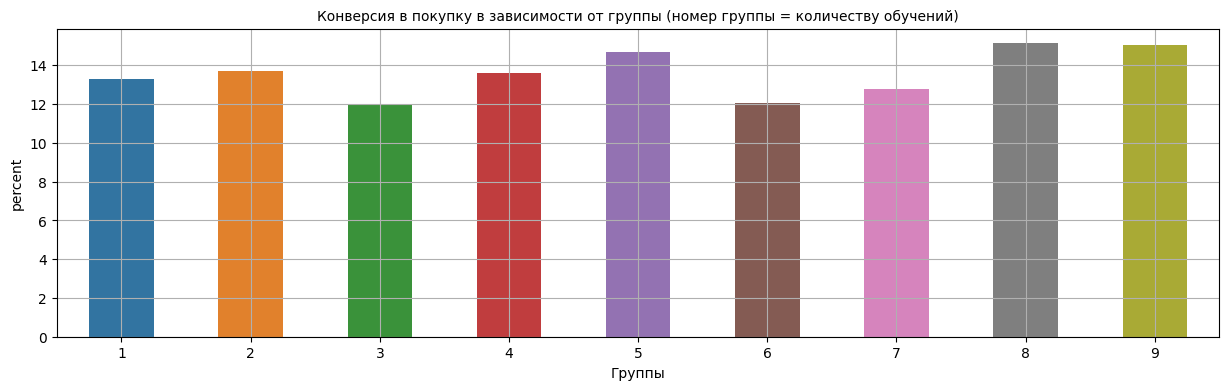

In [66]:
fig, axes = plt.subplots( 1, figsize=(15,4))
barplot1 = sns.barplot(
    data= df2,
    y = 'percent', 
    x = 'number_groups',
    # order = df2.sort_values(by = 'percent', ascending = False).number_groups,
    orient ='v',
    width = 0.5);

barplot1.set_title('Конверсия в покупку в зависимости от группы (номер группы = количеству обучений)', fontsize = (10));
barplot1.grid()
barplot1.set_xlabel('Группы');
    

In [67]:
# отсортируем
df2.sort_values(by ='count_user_id', inplace=True, ascending = False)


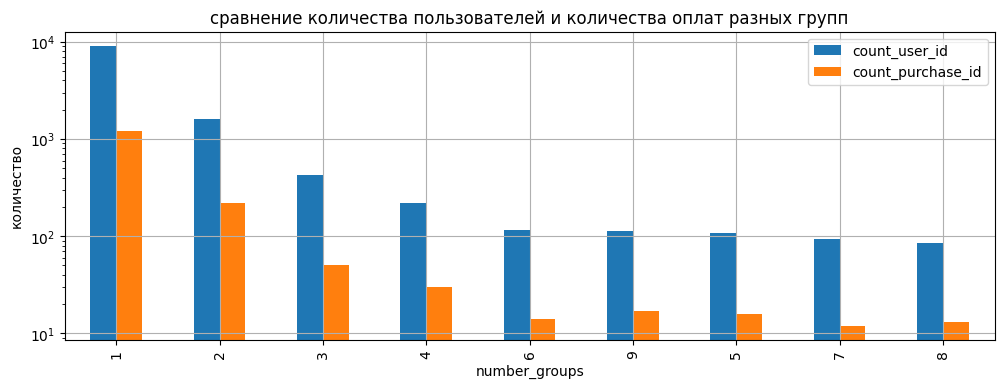

In [68]:
df2[['number_groups', 'count_user_id', 'count_purchase_id']].set_index('number_groups').plot(
    kind='bar',
    grid=True,
    title = 'сравнение количества пользователей и количества оплат разных групп',
    legend = True,
    figsize=(12, 4),
    logy = True,
    ylabel = 'количество'
);
    

обратите внимание на группы 5,6,7,8,9 на графике, отчётливо видно, что количество пользователей и количество оплат, примерно, равномерно распределены у трёх групп.

### можно сделать вывод, что само по себе обучение влияет на вероятность оплаты  не зависит от количества обучений, напомню, что пользователи без обучения совершили 22 покупки, их было 8068.

### Задача 3
#### Определить, насколько прозрачен процесс взаимодействия с игрой.

Выяснить, как часто пользователи начинают обучение после выбора уровня сложности. (Это позволит оценить прозрачность процесса взаимодействия с игрой: если пользователи после выбора уровня сложности обращаются к обучению, значит, работа с приложением непонятна.)

In [69]:
# формирую фильтр по событию : выбор уровня сложности и начала обучения
print(user_paths[user_paths.index.str.contains('level_choice > tutorial_start')].head(10))


event_path
registration > tutorial_start > tutorial_finish > level_choice > tutorial_start > tutorial_finish                                                                          169
registration > tutorial_start > tutorial_finish > level_choice > tutorial_start                                                                                             39
registration > tutorial_start > tutorial_finish > level_choice > tutorial_start > tutorial_finish > tutorial_start > tutorial_finish                                        31
registration > tutorial_start > tutorial_finish > tutorial_start > tutorial_finish > level_choice > tutorial_start > tutorial_finish                                        17
registration > tutorial_start > tutorial_finish > level_choice > tutorial_start > tutorial_finish > tutorial_start > tutorial_finish > tutorial_start > tutorial_finish     12
registration > tutorial_start > tutorial_start > tutorial_finish > level_choice > tutorial_start > tutorial_finish

#### Рассмотрим разные комбинации, где обучение было позже выбора сложности. Для этого вычту из столбца со временем обучения столбец со временем  выбора сложности, если результат будет положительный, то это искомый случай!

In [70]:
# вернёмся к нашему датафрейму
events_2018.head()

,event_id,event_type,selected_level,start_time,tutorial_id,user_id
51405,80308,registration,NaN,2018-01-01T03:48:40,NaN,27832
51406,80309,registration,NaN,2018-01-01T04:07:25,NaN,27833
51407,80310,registration,NaN,2018-01-01T08:35:10,NaN,27834
51408,80311,registration,NaN,2018-01-01T11:54:47,NaN,27835
51409,80312,registration,NaN,2018-01-01T13:28:07,NaN,27836


In [71]:
# формируем датафреймы
level_choice_df = total_events_2018[total_events_2018['event_type'] == 'level_choice'][['user_id', 'start_time']]
tutorial_start_df = total_events_2018[total_events_2018['event_type'] == 'tutorial_start'][['user_id', 'start_time']]

level_choice_df = level_choice_df.rename(
    columns={"start_time": "level_choice_time"}
)
                   
tutorial_start_df = tutorial_start_df.rename(
    columns={"start_time": "tutorial_start_time"}
)                                                   

# объединяею датафреймы
merge_df = tutorial_start_df.merge(level_choice_df, on ='user_id', how = 'inner')               
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12686 entries, 0 to 12685
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              12686 non-null  int64         
 1   tutorial_start_time  12686 non-null  datetime64[ns]
 2   level_choice_time    12686 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1)
memory usage: 396.4 KB


In [72]:
# создаю признак, где будут пользователи, начавшие обучение после выбора сложности
merge_df['time'] = merge_df.tutorial_start_time - merge_df.level_choice_time
merge_df['time'] = merge_df['time']/pd.Timedelta(hours = 1) 
merge_df = merge_df[merge_df['time'] > 0]
display(merge_df)

# считаем пользователей
print(merge_df.user_id.nunique(), '- количество пользователей, которые начинают обучение после выбора сложности' + 
      ' и доля таких пользователей от общего количества: ', 
      round(100 * merge_df.user_id.nunique()/count_all_users,2), '%')


,user_id,tutorial_start_time,level_choice_time,time
4,27842,2018-01-02 09:01:51,2018-01-02 08:46:03,0.263333
5,27842,2018-01-02 18:08:01,2018-01-02 08:46:03,9.366111
8,27845,2018-01-02 07:08:00,2018-01-02 06:19:18,0.811667
13,27852,2018-01-02 20:34:31,2018-01-02 18:39:44,1.913056
21,27862,2018-01-03 11:17:41,2018-01-03 04:19:32,6.969167
...,...,...,...,...
12630,47635,2018-12-28 17:28:42,2018-12-28 11:43:38,5.751111
12643,47657,2018-12-28 21:44:13,2018-12-28 21:25:49,0.306667
12644,47657,2018-12-28 21:53:06,2018-12-28 21:25:49,0.454722
12666,47711,2018-12-29 22:50:57,2018-12-29 21:23:23,1.459444


1386 - количество пользователей, которые начинают обучение после выбора сложности и доля таких пользователей от общего количества:  6.96 %


### Ответ: около 7% пользователей начинают обучение после выбора уровня сложности